## Task 2. Streaming application using Spark Structured Streaming

## 2.1

In [ ]:
# import libary
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, decode, expr,lit,udf
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml import PipelineModel
import pandas as pd


# Spark
conf = SparkConf().setAppName("Streaming application").setMaster("local[*]").set("spark.sql.session.timeZone", "UTC")
spark = SparkSession.builder.config(conf = conf).getOrCreate()

## 2.2

In [ ]:
# Define the data schema for sensor location CSV file.
sensor_schema = StructType([StructField("sensor_id", IntegerType(),True),
                          StructField("sensor_description", StringType(),True),
                          StructField("sensor_name", StringType(),True),
                          StructField("installation_date", DateType(),True),
                          StructField("status", StringType(),True),
                          StructField("note", StringType(),True),  
                          StructField("direction_1", StringType(),True),
                          StructField("direction_2", StringType(),True),
                          StructField("latitude", FloatType(),True),
                          StructField("longitude", FloatType(),True),
                          StructField("location", StringType(),True)
                          ])


# Load CSV file into dataframe
df_sensor = spark.read.csv('Pedestrian_Counting_System_-_Sensor_Locations.csv',dateFormat ='yyyy/MM/dd',schema = sensor_schema,header=True)

## 2.3

In [ ]:
# Get the streaming data
topic = "December_count"
df_count = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

# Cast data in string type
raw_data = df_count.selectExpr("CAST(value AS STRING)")

# Define the raw_schema
raw_schema = StructType([StructField("ID", StringType(),True),
                          StructField("Date_Time", StringType(),True),
                          StructField("Year", StringType(),True),
                          StructField("Month", StringType(),True),
                          StructField("Mdate", StringType(),True),
                          StructField("Day", StringType(),True),  
                          StructField("Time", StringType(),True),
                          StructField("Sensor_ID", StringType(),True),
                          StructField("Sensor_Name", StringType(),True),
                          StructField("Hourly_Counts", StringType(),True)
                          ])

# Get the raw data
df = raw_data.select(F.from_json(F.col('value').cast('string'), raw_schema).alias('value'))

# Change the column name
df = df.select(
            F.col('value.ID').alias('ID'),
            F.col('value.Date_Time').alias('Date_Time'),
            F.col('value.Year').alias('Year'),
            F.col('value.Month').alias('Month'),
            F.col('value.Mdate').alias('Mdate'),
            F.col('value.Day').alias('Day'),
            F.col('value.Time').alias('Time'),
            F.col('value.Sensor_ID').alias('Sensor_ID'),
            F.col('value.Sensor_Name').alias('Sensor_Name'),
            F.col('value.Hourly_Counts').alias('Hourly_Counts'),
            )  

## 2.4

In [ ]:
# Persist the raw streaming data in parquet format
counts_parquet = df \
    .writeStream\
    .format("parquet") \
    .option("path", "parquet/counts_parquet")\
    .option("checkpointLocation", "parquet/clickstream_df/checkpoint")\
    .start()

## 2.5

In [ ]:
# Transformed data into the proper formats
df = df.withColumn('ID',F.col('ID').cast(IntegerType()))\
    .withColumn('Date_Time',F.to_timestamp('Date_Time', 'MM/dd/yyyy hh:mm:ss a'))\
    .withColumn('Year',F.col('Year').cast(IntegerType()))\
    .withColumn('Mdate',F.col('Mdate').cast(IntegerType()))\
    .withColumn('Time',F.col('Time').cast(IntegerType()))\
    .withColumn('Sensor_ID',F.col('Sensor_ID').cast(IntegerType()))\
    .withColumn('Hourly_Counts',F.col('Hourly_Counts').cast(IntegerType()))

## 2.6

In [ ]:
# Filter data count between 9am-11:59pm
df = df.filter((df['Time']>= 9) & (df['Time']<=11))

In [ ]:
# Create 'next_date','next_Mdate','next_day_week' and 'next_day_of_week' columns
# For next_day_of_week, because the monday is first day of week and dayofweek() function based on sunday is first day of week. 
# So I sub one day in next_date in order to get correct next_day_of_week

df = df.withColumn('next_date',F.date_add(F.to_date(F.col('Date_Time')),1))\
    .withColumn('next_Mdate', F.dayofmonth(F.col('next_date')))\
    .withColumn('next_day_week', F.weekofyear(F.col('next_date')))\
    .withColumn('next_day_of_week', F.dayofweek(F.date_sub(F.col('next_date'),1)))\
    .withColumnRenamed('Hourly_Counts', 'prev_count')

## 2.7

In [ ]:
# Load the pipeline
pipelineModel = PipelineModel.load('count_estimation_pipeline_model')

In [ ]:
# Use pipeline model to transform df
df_pred = pipelineModel.transform(df)

In [ ]:
# Persist the prediction result in parquet format
pred_parquet = df_pred \
    .writeStream\
    .format("parquet") \
    .option("path", "parquet/pred_parquet")\
    .option("checkpointLocation", "parquet/clickstream_df/checkpoint")\
    .start()

## 2.8

In [ ]:
# task a

# Filter the prediction more than 2000
df_exceed = df_pred.filter(df_pred['prediction'] > 2000)

# Use 1 day window and group yb sensor_ID to get a df including sensor_id, date and count.
df_exceed = df_exceed\
        .groupBy('Sensor_ID',F.window('Date_Time','1 day'))\
        .count()\
        .select('Sensor_ID',F.to_date(F.col('window').start).alias('Date') , 'count')

In [ ]:
# Use writeStrea to store df in memory format.
query_1 = df_exceed \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("exceed_hours_num") \
    .trigger(processingTime='5 seconds') \
    .start()

In [ ]:
# use sql to display the result
spark.sql("select * from exceed_hours_num order by Date").show()

This is the first 20 rows in exceed_hours_num
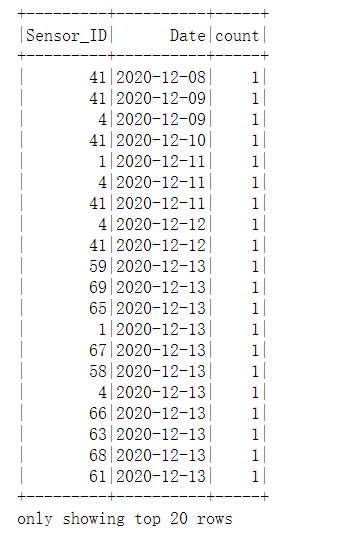

In [ ]:
query_1.stop()

In [ ]:
# task b

# Join the df_exceed and df_sensor to get each sensor that prediction exceed 2000 location information.
df_map = df_exceed.join(df_sensor, on = 'Sensor_ID', how ='inner')\
    .select('Sensor_ID','Date','latitude','longitude')

In [ ]:
# Convet date column to key and other column as value.
df_final = df_map.withColumn('value',F.to_json(F.struct(df_map.columns)))\
    .withColumn('key', F.col('Date'))\
    .select(F.col('key').cast('String'),'value')

In [ ]:
# Stream back to kafka using sensor_loc topic name
kafka_sink = df_final\
    .writeStream\
    .format('kafka')\
    .outputMode('update')\
    .option('kafka.bootstrap.servers', '127.0.0.1:9092')\
    .option('topic','sensor_loc')\
    .option('checkpointLocation','kafka/checkpoint')\
    .trigger(processingTime = '5 seconds')\
    .start()